In [69]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
# auto-arima model
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff

In [48]:
default = (10, 5)
sns.set_style("darkgrid")

In [49]:
df = pd.read_csv("../ST1511-CA2-dataset/Energy Consumption Dataset.csv")
df.head()

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4


In [50]:
df_eda = df.copy()

In [51]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [52]:
df_eda.shape

(397, 4)

In [53]:
df_eda.describe()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
count,397.000000,397.000000,397.000000
mean,23.785139,888.472544,484.953652
std,4.903452,153.877594,133.908863
min,11.600000,553.200000,44.400000
25%,20.200000,771.100000,384.400000
50%,23.500000,897.800000,487.400000
75%,27.900000,1005.200000,580.200000
max,46.000000,1294.000000,811.000000


In [54]:
df_eda.isna().sum()

DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

In [55]:
df['Date'] = pd.to_datetime(df['DATE'], format="%d/%m/%Y")
df = df.drop(["DATE"], axis=1)
df.set_index('Date', inplace=True)
display(df)

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
Date,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


In [56]:
prof = ProfileReport(df_eda, explorative=True)

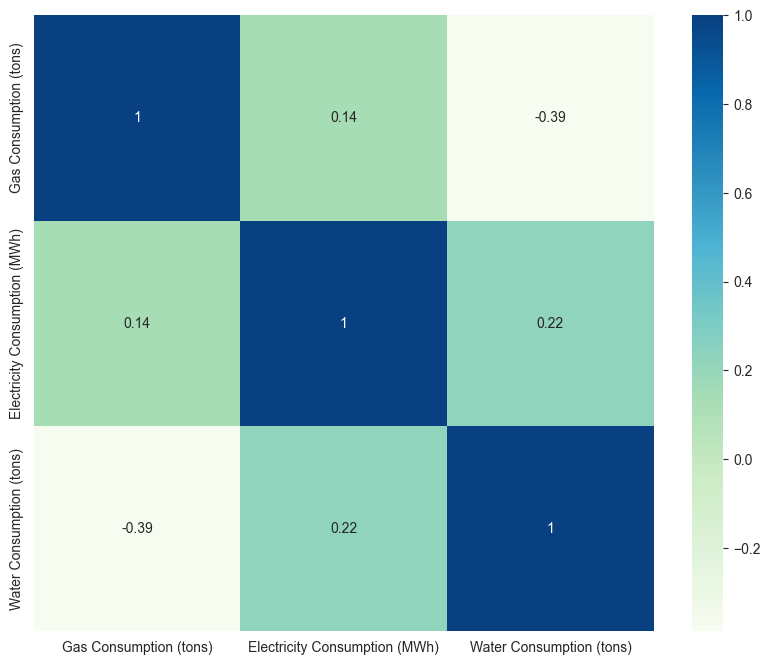

In [57]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="GnBu")
plt.show()

In [58]:
monthly_gas = df[['Gas Consumption (tons)']]#.mean()
monthly_gas.head()

,Gas Consumption (tons)
Date,
1990-01-01,18.0
1990-02-01,15.8
1990-03-01,17.3
1990-04-01,18.9
1990-05-01,22.0


In [59]:
monthly_electricity = df[['Electricity Consumption (MWh)']]#.mean()
monthly_electricity.head()

,Electricity Consumption (MWh)
Date,
1990-01-01,725.1
1990-02-01,706.7
1990-03-01,624.5
1990-04-01,574.7
1990-05-01,553.2


In [60]:
monthly_water = df[['Water Consumption (tons)']]#.mean()
monthly_water.head()

,Water Consumption (tons)
Date,
1990-01-01,548.8
1990-02-01,640.7
1990-03-01,511.1
1990-04-01,515.3
1990-05-01,488.4


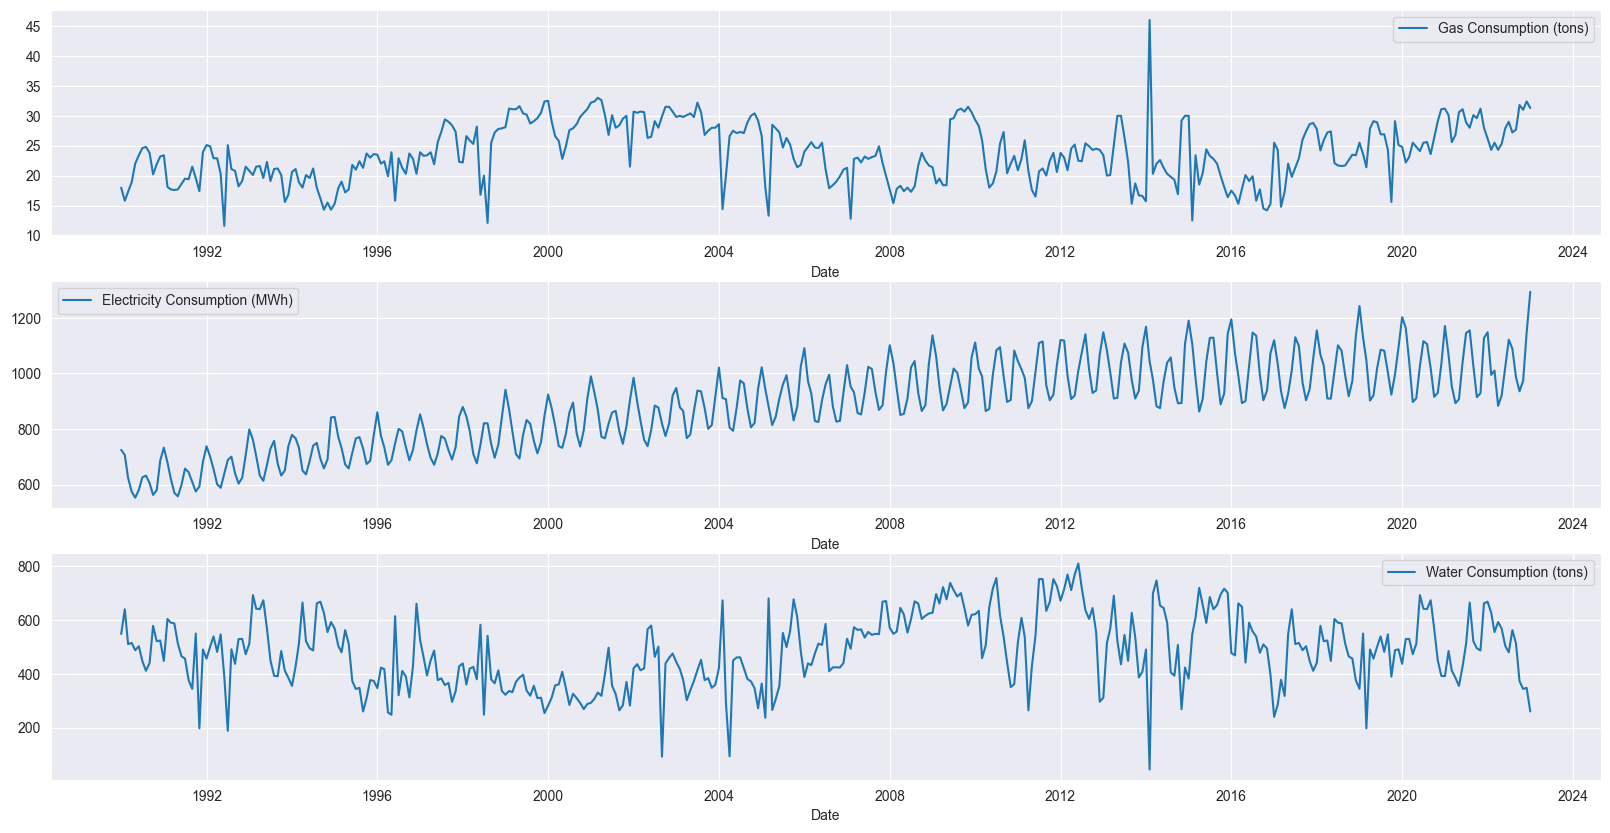

In [61]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
for i, part in enumerate([monthly_gas, monthly_electricity, monthly_water]):
    sns.lineplot(part, ax=ax[i])
plt.show()

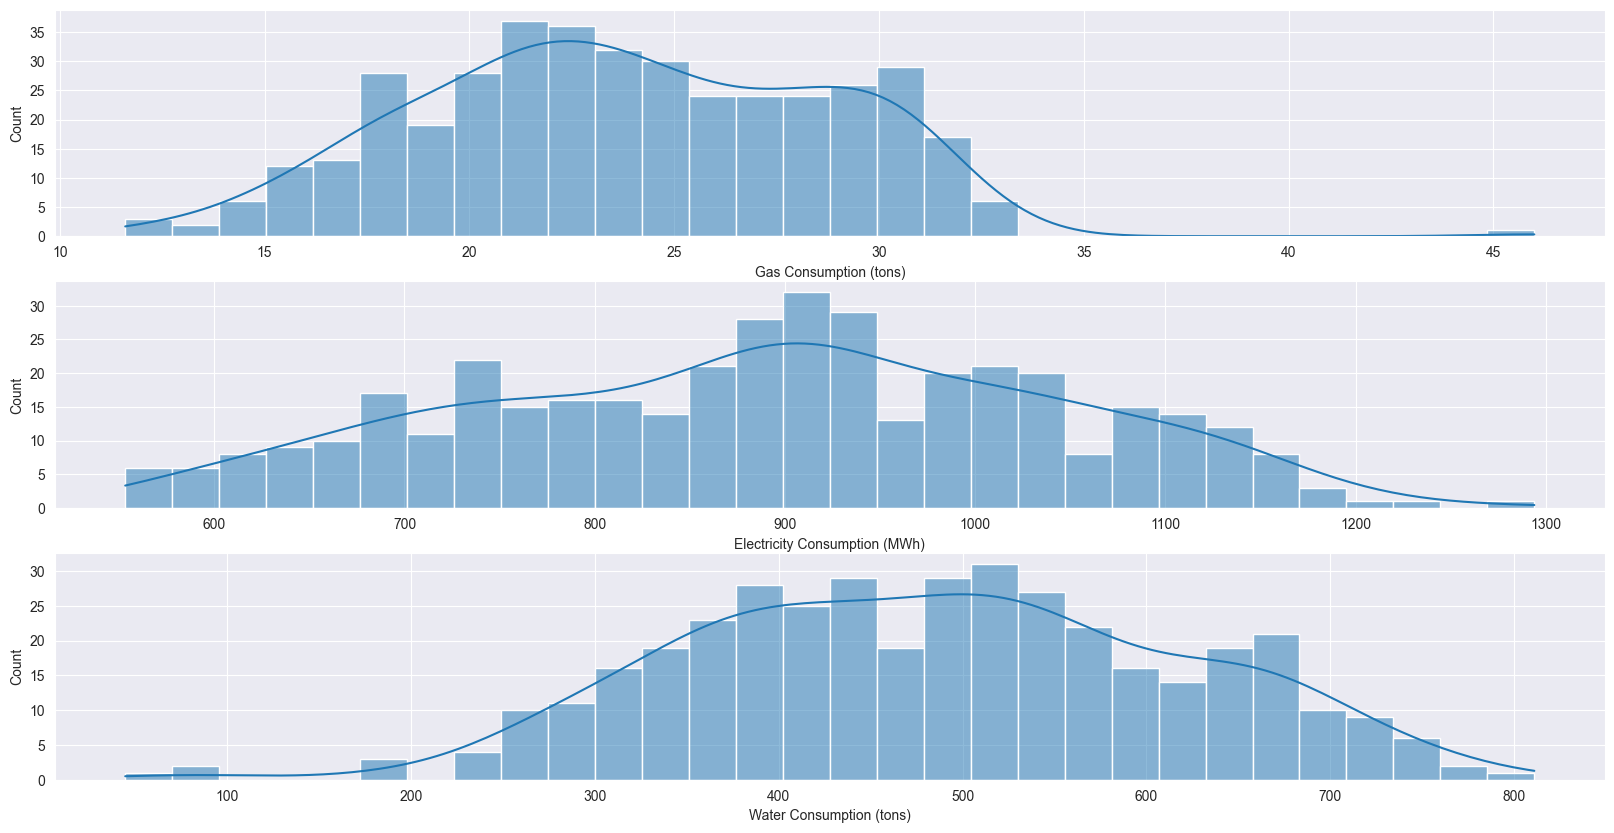

In [62]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))

for i, x_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    sns.histplot(data=df, x=x_temp, bins=30, ax=ax[i], kde=True)

In [63]:
display(df)

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
Date,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


In [65]:
X1 = df.iloc[:len(df)//2, 0]
X2 = df.iloc[len(df)//2:, 0]
print(f'group 1 mean = {X1.mean():.2f}, group 2 mean = {X1.mean():.2f}, \ngroup 1 variance = {X1.var():.2f}, group 2 variance = {X2.var():.2f}')

group 1 mean = 24.28, group 2 mean = 24.28, 
group 1 variance = 24.48, group 2 variance = 23.23


In [68]:
for i, x_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    result = adfuller(df[x_temp])
    print(x_temp, 'p-value: %f' % result[1])

Gas Consumption (tons) p-value: 0.010811
Electricity Consumption (MWh) p-value: 0.186218
Water Consumption (tons) p-value: 0.000090


Air Paseenger before differencing p-value: 0.010811
Air Paseenger after differencing p-value: 0.000000


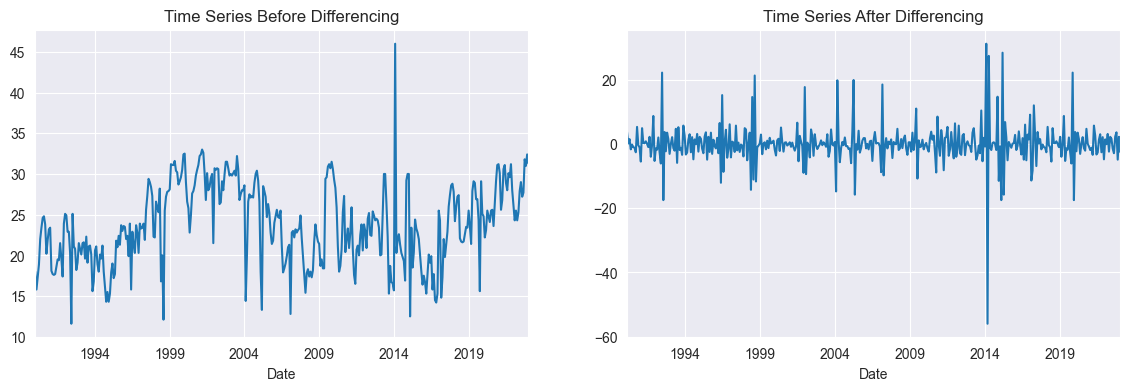

Air Paseenger before differencing p-value: 0.186218
Air Paseenger after differencing p-value: 0.000000


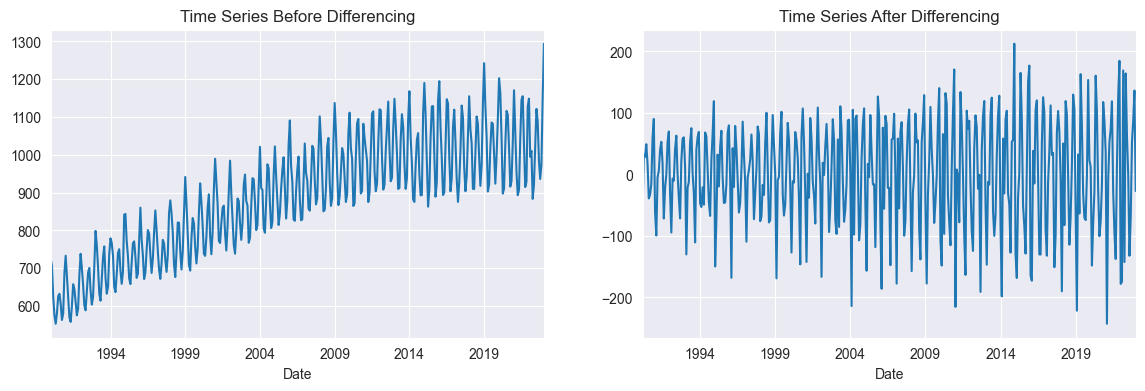

Air Paseenger before differencing p-value: 0.000090
Air Paseenger after differencing p-value: 0.000000


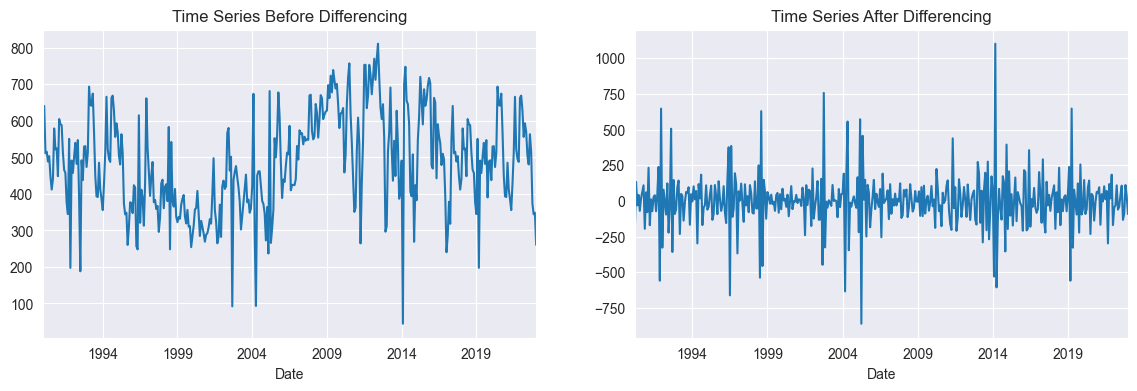

In [73]:
for i, x_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    df_diff = diff(df[x_temp], k_diff=2)
    result1 = adfuller(df[x_temp])
    result2 = adfuller(df_diff)
    print('Air Paseenger before differencing p-value: %f' % result1[1])
    print('Air Paseenger after differencing p-value: %f' % result2[1])
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    df[x_temp].plot(ax=ax[0])
    df_diff.plot(ax=ax[1])
    ax[0].set_title('Time Series Before Differencing')
    ax[1].set_title('Time Series After Differencing')
    plt.show()